In [40]:
## Importing Libraries 
import re
import os
# import cv2 
import json
from time import time
import pickle
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Tensorflow related libraries
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add
from tensorflow.keras import Input
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# ## Keras libraries
# from keras.preprocessing import sequence, image
# from keras.models import Sequential
# from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
#                          Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
# 
# from keras.optimizers import Adam, RMSprop
# from keras.layers.wrappers import Bidirectional
# from keras.layers.merge import add
# from keras.applications.inception_v3 import InceptionV3
# from keras.preprocessing import image
# from keras.models import Model
# from keras import Input, layers
# from keras import optimizers
# from keras.applications.inception_v3 import preprocess_input
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical

In [2]:
tf.__version__

'2.1.0'

In [3]:
def readText(path): 
    with open(path) as f: 
        captions = f.read() 
        
    return captions 

captions = readText("captions.csv") 
captions = captions.split("\n") 

In [4]:
descriptions = {}

for i in range(1, len(captions)):
    image, *caption = captions[i].split(",")
    image = image.split(".")[0]
    
    if not descriptions.get(image):
        descriptions[image] = []
        
    try:
        descriptions[image].append(caption[0])
    except Exception: 
        pass

In [5]:
descriptions["1007129816_e794419615"]

['A man in an orange hat starring at something .',
 'A man wears an orange hat and glasses .',
 'A man with gauges and glasses is wearing a Blitz hat .',
 'A man with glasses is wearing a beer can crocheted hat .',
 'The man with pierced ears is wearing glasses and an orange hat .']

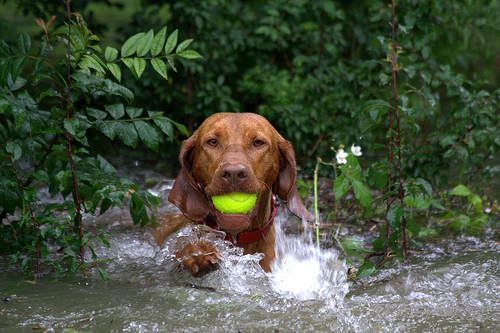

In [6]:
from PIL import Image
from IPython.display import display

img = Image.open("images/"+"1130369873_d80a1aa59c.jpg")
display(img)

In [7]:
import numpy as np
np.array(img)

array([[[ 28,  49,   6],
        [ 30,  54,   6],
        [ 34,  54,   5],
        ...,
        [ 54,  85,  44],
        [ 49,  78,  48],
        [ 49,  75,  50]],

       [[ 35,  53,  13],
        [ 33,  56,  12],
        [ 34,  53,   8],
        ...,
        [ 56,  86,  48],
        [ 48,  77,  47],
        [ 47,  73,  48]],

       [[ 41,  57,  20],
        [ 39,  60,  21],
        [ 35,  53,  13],
        ...,
        [ 58,  88,  52],
        [ 51,  80,  52],
        [ 49,  77,  54]],

       ...,

       [[ 72,  81,  64],
        [ 68,  79,  62],
        [ 67,  78,  61],
        ...,
        [106, 103,  94],
        [105, 103,  91],
        [111, 109,  97]],

       [[ 71,  78,  62],
        [ 70,  79,  62],
        [ 70,  81,  64],
        ...,
        [147, 145, 132],
        [122, 120, 105],
        [ 99,  98,  80]],

       [[ 74,  78,  64],
        [ 74,  82,  67],
        [ 75,  86,  70],
        ...,
        [116, 117, 101],
        [105, 104,  84],
        [104, 102,  81]]

In [8]:
# import cv2 
# import matplotlib.pyplot as plt


IMG_PATH = "images/"
# img = cv2.imread(IMG_PATH + "1007129816_e794419615.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.axis("off");

In [9]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+", " ", sentence)  ## Removing any number and punctuations
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s) > 1] ## Only keeping words with length more than one
    sentence = " ".join(sentence)
    return sentence

In [10]:
clean_text("A cat is sitting over the house 35")

'cat is sitting over the house'

In [11]:
# Clean captions
for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [12]:
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with p

In [13]:
len(descriptions)

8092

In [14]:
## Saving it to text file
with open("descriptions.txt", "w") as f:
    f.write(str(descriptions))

In [15]:
## Importing descriptions dictionary
with open("descriptions.txt", "r") as f:
    descriptions = f.read()
    descriptions = json.loads(descriptions.replace("\'", "\""))
    
print(type(descriptions))

<class 'dict'>


In [16]:
## Creating unique words list
vocab = set()

for key in descriptions.keys(): 
    for sentence in descriptions[key]: 
        vocab.update(sentence.split())

In [17]:
len(vocab)

8257

In [20]:
## Total number of words
total_words = []

for key in descriptions.keys():
    for sentence in descriptions[key]:
        for word in sentence.split():
            total_words.append(word)

In [21]:
len(total_words)

357791

In [22]:
## Creating word counter
counter = Counter(total_words)
freq_count = dict(counter)

## Sorting words according to their count
sorted_freq_count = sorted(freq_count.items(), reverse=True, key= lambda x: x[1])

In [23]:
len(freq_count.keys()), len(vocab), len(sorted_freq_count)

(8257, 8257, 8257)

In [24]:
## Filtering out the words
threshold = 10
sorted_freq_count = [x for x in sorted_freq_count if x[1] > threshold]

total_words = [x[0] for x in sorted_freq_count]
total_words

['in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'two',
 'white',
 'black',
 'boy',
 'are',
 'woman',
 'girl',
 'to',
 'wearing',
 'people',
 'at',
 'water',
 'young',
 'red',
 'brown',
 'an',
 'his',
 'blue',
 'dogs',
 'running',
 'through',
 'playing',
 'shirt',
 'while',
 'down',
 'little',
 'standing',
 'ball',
 'grass',
 'person',
 'child',
 'snow',
 'jumping',
 'over',
 'three',
 'front',
 'sitting',
 'small',
 'up',
 'field',
 'holding',
 'large',
 'group',
 'by',
 'green',
 'yellow',
 'children',
 'walking',
 'men',
 'her',
 'into',
 'beach',
 'air',
 'near',
 'jumps',
 'mouth',
 'street',
 'runs',
 'for',
 'another',
 'riding',
 'from',
 'its',
 'as',
 'bike',
 'stands',
 'girls',
 'one',
 'outside',
 'rock',
 'off',
 'player',
 'next',
 'play',
 'out',
 'pink',
 'orange',
 'looking',
 'pool',
 'other',
 'camera',
 'their',
 'boys',
 'jacket',
 'women',
 'hat',
 'around',
 'some',
 'dirt',
 'soccer',
 'sits',
 'behind',
 'toy',
 'dressed',
 'mountain',
 'w

In [25]:
## Total number of possible output words
len(total_words)

1800

In [26]:
## Dividing images into three parts
imgs = list(descriptions.keys())
train_data = imgs[:6092]
dev_data = imgs[6092:7092]
test_data = imgs[7092:]

In [27]:
len(train_data), len(dev_data), len(test_data)

(6092, 1000, 1000)

In [29]:
## Saving into text files
flickr8k_trainData = ".jpg\n".join(train_data)
flickr8k_testData = ".jpg\n".join(test_data)
flickr8k_devData = ".jpg\n".join(dev_data)

with open("Flickr8k.trainImages.txt", "w") as f1:
    f1.write(flickr8k_trainData)
with open("Flickr8k.testImages.txt", "w") as f2:
    f2.write(flickr8k_testData)
with open("Flickr8k.devImages.txt", "w") as f3:
    f3.write(flickr8k_devData)

In [30]:
train_data

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615',
 '1007320043_627395c3d8',
 '1009434119_febe49276a',
 '1012212859_01547e3f17',
 '1015118661_980735411b',
 '1015584366_dfcec3c85a',
 '101654506_8eb26cfb60',
 '101669240_b2d3e7f17b',
 '1016887272_03199f49c4',
 '1019077836_6fc9b15408',
 '1019604187_d087bf9a5f',
 '1020651753_06077ec457',
 '1022454332_6af2c1449a',
 '1022454428_b6b660a67b',
 '1022975728_75515238d8',
 '102351840_323e3de834',
 '1024138940_f1fefbdce1',
 '102455176_5f8ead62d5',
 '1026685415_0431cbf574',
 '1028205764_7e8df9a2ea',
 '1030985833_b0902ea560',
 '103106960_e8a41d64f8',
 '103195344_5d2dc613a3',
 '103205630_682ca7285b',
 '1032122270_ea6f0beedb',
 '1032460886_4a598ed535',
 '1034276567_49bb87c51c',
 '104136873_5b5d41be75',
 '1042020065_fb3d3ba5ba',
 '1042590306_95dea0916c',
 '1045521051_108ebc19be',
 '1048710776_bb5b0a5c7c',
 '1052358063_eae6744153',
 '105342180_4d4a40b47f',
 '1053804096_ad278b25

In [31]:
## Creating input descriptions for training with start and end symbols
train_descriptions = {}
 
### Adding start and end token to the traning sentences
for img_id in train_data:
    train_descriptions[img_id] = []
    for caption in descriptions[img_id]:
        cap_to_append = "startseq " + caption + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [32]:
train_descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tri colored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow ends

In [33]:
## Creating ResNet50 model
model = ResNet50(weights="imagenet", input_shape=(224, 224, 3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [34]:
model.layers[-2], model.input

(<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D at 0x245c09259c8>,
 <tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>)

In [35]:
new_model = Model(model.input, model.layers[-2].output)

In [36]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [37]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224, 224, 3))
    img = image.img_to_array(img)
    
    img = np.expand_dims(img, axis=0) 
    img = preprocess_input(img)
    
    return img

In [38]:
descriptions["1130369873_d80a1aa59c"]

['brown dog is running through neck deep water carrying tennis ball',
 'brown dog splashes in the water while carrying ball in its mouth',
 'brown dog swims through water outdoors with tennis ball in its mouth',
 'red dog',
 'brown dog with tennis ball in mouth']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


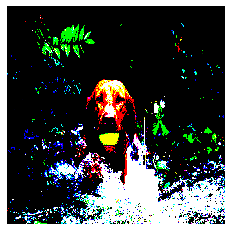

In [41]:
## Testing preprocess image function
test_img = preprocess_image(IMG_PATH + "1130369873_d80a1aa59c.jpg")
plt.imshow(test_img[0][:, :, [2, 1, 0]])
plt.axis("off")
plt.show();

In [42]:
(test_img)

array([[[[ -97.939    ,  -62.779    ,  -93.68     ],
         [ -99.939    ,  -79.779    , -100.68     ],
         [ -97.939    ,  -92.779    , -116.68     ],
         ...,
         [ -67.939    ,  -10.778999 ,  -53.68     ],
         [ -60.939003 ,  -23.779    ,  -64.68     ],
         [ -55.939003 ,  -38.779    ,  -74.68     ]],

        [[ -82.939    ,  -56.779    ,  -84.68     ],
         [ -94.939    ,  -78.779    , -101.68     ],
         [ -85.939    ,  -74.779    , -105.68     ],
         ...,
         [ -55.939003 ,  -10.778999 ,  -52.68     ],
         [ -51.939003 ,  -22.779    ,  -60.68     ],
         [ -51.939003 ,  -36.779    ,  -72.68     ]],

        [[ -77.939    ,  -53.779    ,  -80.68     ],
         [ -89.939    ,  -74.779    , -100.68     ],
         [ -80.939    ,  -65.779    ,  -95.68     ],
         ...,
         [ -51.939003 ,  -10.778999 ,  -54.68     ],
         [ -51.939003 ,  -25.779    ,  -64.68     ],
         [ -48.939003 ,  -33.779    ,  -70.68     ]],

In [43]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [44]:
encode_image(IMG_PATH + "1130369873_d80a1aa59c.jpg")

array([0.27290016, 0.9688181 , 0.32253045, ..., 1.5391469 , 1.4217577 ,
       0.3807983 ], dtype=float32)

In [ ]:
# ### for training images
# encoding_train = {}

# def encode_images(data, encoding_dict):
#     start = time()

#     for ix, img_id in enumerate(data):
#         img_path = IMG_PATH + "/" + img_id + ".jpg"
#         try:
#             encoding_dict[img_id] = encode_image(img_path)
#         except Exception:
#             pass

#         if ix%100 == 0:
#             ep_time = time()
#             print("[+] Encoding done with %d images...."%ix)
#             print("[+] Time taken was %d seconds\n"%(ep_time-start))

#     end_t = time()
#     print("Total time Taken :", end_t-start)

# encode_images(train_data, encoding_train)

In [45]:
## Importing train & test features
encoding_train = {}
target ="encoded_train_features.pkl"

if os.path.getsize(target) > 0:
    with open(target, "rb") as f:
        encoding_train = pickle.load(f)


encoding_test = {}
target ="encoded_test_features.pkl"

if os.path.getsize(target) > 0:
    with open(target, "rb") as f:
        encoding_test = pickle.load(f)
    
encoding_train, encoding_test

({'1000268201_693b08cb0e': array([0.06535939, 0.1678257 , 0.32517606, ..., 0.05107136, 0.32821196,
         1.0043372 ], dtype=float32),
  '1001773457_577c3a7d70': array([0.7841801 , 0.81896996, 0.064914  , ..., 0.08858448, 0.68538105,
         0.18749648], dtype=float32),
  '1002674143_1b742ab4b8': array([0.08411242, 0.6138118 , 0.20675601, ..., 0.        , 3.091057  ,
         1.5624398 ], dtype=float32),
  '1003163366_44323f5815': array([0.13873969, 0.13371009, 0.21037507, ..., 0.3128755 , 0.43861872,
         0.586484  ], dtype=float32),
  '1007129816_e794419615': array([0.07020099, 0.4670935 , 0.        , ..., 0.01412521, 0.        ,
         0.0498566 ], dtype=float32),
  '1007320043_627395c3d8': array([0.5257977 , 0.3707962 , 0.        , ..., 0.00266837, 0.29757205,
         0.11049528], dtype=float32),
  '1009434119_febe49276a': array([0.05470392, 0.01779996, 0.1759316 , ..., 0.10565771, 0.2666015 ,
         0.22671774], dtype=float32),
  '1012212859_01547e3f17': array([0.26615

In [46]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [47]:
idx_to_word, word_to_idx

({1: 'in',
  2: 'the',
  3: 'on',
  4: 'is',
  5: 'and',
  6: 'dog',
  7: 'with',
  8: 'man',
  9: 'of',
  10: 'two',
  11: 'white',
  12: 'black',
  13: 'boy',
  14: 'are',
  15: 'woman',
  16: 'girl',
  17: 'to',
  18: 'wearing',
  19: 'people',
  20: 'at',
  21: 'water',
  22: 'young',
  23: 'red',
  24: 'brown',
  25: 'an',
  26: 'his',
  27: 'blue',
  28: 'dogs',
  29: 'running',
  30: 'through',
  31: 'playing',
  32: 'shirt',
  33: 'while',
  34: 'down',
  35: 'little',
  36: 'standing',
  37: 'ball',
  38: 'grass',
  39: 'person',
  40: 'child',
  41: 'snow',
  42: 'jumping',
  43: 'over',
  44: 'three',
  45: 'front',
  46: 'sitting',
  47: 'small',
  48: 'up',
  49: 'field',
  50: 'holding',
  51: 'large',
  52: 'group',
  53: 'by',
  54: 'green',
  55: 'yellow',
  56: 'children',
  57: 'walking',
  58: 'men',
  59: 'her',
  60: 'into',
  61: 'beach',
  62: 'air',
  63: 'near',
  64: 'jumps',
  65: 'mouth',
  66: 'street',
  67: 'runs',
  68: 'for',
  69: 'another',
  70: 'ri

In [48]:
len(idx_to_word)

1800

In [49]:
## Adding two special words
idx_to_word[1801] = "startseq"
word_to_idx["startseq"] = 1801

idx_to_word[1802] = "endseq"
word_to_idx["endseq"] = 1802
 
vocab_size = len(word_to_idx) + 1  ## plus one to keep zero index for padding and start 

In [50]:
len(word_to_idx), vocab_size

(1802, 1803)

In [51]:
## Saving w2i && i2w
with open("word_to_idx.pkl", "wb") as w2i:
    pickle.dump(word_to_idx, w2i)
    
with open("idx_to_word.pkl", "wb") as i2w:
    pickle.dump(idx_to_word, i2w)

In [52]:
## Calculating the max length of a sentence
max_len = 0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))
        
print(max_len)

31


In [53]:
### Creating word embedding dictionary
embedding_index = {}

### GloVe is an unsupervised learning algorithm for obtaining vector representations for words.
with open("glove.6B.50d.txt", mode="r", encoding="utf-8") as f:    
    for line in f:
        values = line.split()
        
        word = values[0]
        word_embedding = np.array(values[1:], dtype="float")
        
        embedding_index[word] = word_embedding

In [54]:
embedding_index["music"]

array([-0.92448  ,  0.59807  , -0.995    , -0.045298 , -0.38836  ,
        0.032817 , -1.1416   , -0.30202  , -0.33753  ,  2.0498   ,
        0.72614  ,  0.25759  ,  0.062278 ,  0.60505  ,  0.19414  ,
       -0.33841  ,  0.0098585,  0.28398  , -0.025021 , -0.53623  ,
        1.2342   ,  1.0731   , -0.087618 ,  0.99114  ,  0.49666  ,
       -0.46601  , -1.7859   , -0.50884  , -0.67744  , -0.91626  ,
        3.6685   , -0.58218  ,  0.72491  , -0.47676  , -0.35207  ,
        0.041236 ,  0.27288  , -0.205    , -0.1238   ,  0.10142  ,
        0.59449  ,  0.27638  , -0.92749  , -0.63906  , -0.13326  ,
        0.50902  ,  0.15386  , -0.86544  , -1.3564   ,  0.28513  ])

In [55]:
embedding_dim = 50
def get_embedding_matrix():
    embedding_dim = 50
    matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [56]:
embedding_matrix = get_embedding_matrix()
embedding_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.33042 ,  0.24995 , -0.60874 , ..., -0.50703 , -0.027273,
        -0.53285 ],
       [ 0.418   ,  0.24968 , -0.41242 , ..., -0.18411 , -0.11514 ,
        -0.78581 ],
       ...,
       [-0.34126 , -0.06117 ,  0.93339 , ..., -0.5682  , -0.6244  ,
         0.30874 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [57]:
embedding_matrix.shape

(1803, 50)

In [58]:
embedding_index.get("cannon")

array([-0.34126 , -0.06117 ,  0.93339 , -0.48938 , -0.16882 ,  0.76947 ,
        0.11972 , -0.11674 , -0.54492 , -0.44433 , -0.44316 , -0.10517 ,
       -0.086709,  0.13392 , -1.0489  , -0.10756 ,  0.4921  ,  0.62526 ,
       -1.5142  , -0.88477 ,  0.28845 ,  0.26258 ,  0.10793 , -0.92586 ,
       -0.043537, -0.67035 ,  0.22245 ,  0.28499 ,  0.32135 , -0.22713 ,
        1.0602  , -0.89463 , -0.14558 , -0.041262,  0.19645 ,  0.65909 ,
        0.85064 , -0.34087 ,  0.19177 ,  0.49908 ,  1.0036  ,  0.70362 ,
       -0.41316 , -0.47519 ,  0.94353 ,  0.14839 , -0.42612 , -0.5682  ,
       -0.6244  ,  0.30874 ])

In [59]:
with open("embedding_matrix.txt", "wb") as f:
    f.write(embedding_matrix)

In [ ]:
# ### Tensorflow related libraries
# import tensorflow as tf
# from tensorflow.keras.applications.vgg16 import VGG16
# from keras.preprocessing import image
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.layers import Add
# from tensorflow.keras import Input
# from tensorflow.keras.layers import InputLayer, Dense, Dropout, Embedding, LSTM
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [60]:
final_model = load_model("final_model_19.h5")

In [61]:
## Keras Library imports
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
# ## Using keras functional API to create the merge model 

# ### Image feature extractor model
# inputs1 = Input(shape=(2048,))
# fe1 = Dropout(0.5)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)

# ### Partial caption sequence model
# inputs2 = Input(shape=(max_len,))
# se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
# se2 = Dropout(0.5)(se1)
# se3 = LSTM(256)(se2)    ## where 256 is the size of output vector

# ### Decoder feed forward network
# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation="relu")(decoder1)
# outputs = Dense(vocab_size, activation="softmax")(decoder2)

# ### Merging the two models
# final_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [62]:
encoding_test

{'379006645_b9a2886b51': array([0.21914157, 0.5719447 , 0.        , ..., 0.6068711 , 0.03087302,
        0.36044884], dtype=float32),
 '380034515_4fbdfa6b26': array([0.29137012, 0.01306508, 0.6393796 , ..., 0.00232906, 0.08223425,
        0.14293307], dtype=float32),
 '380041023_0dfd712ef1': array([0.02699727, 0.09202066, 0.11031401, ..., 0.12098099, 0.19906935,
        0.15357533], dtype=float32),
 '380515798_c2abbf46b0': array([0.19967817, 0.04460802, 0.35637164, ..., 0.18070194, 0.71839666,
        0.29161525], dtype=float32),
 '380527679_574749123d': array([0.0434575 , 1.7292324 , 0.18306491, ..., 0.17492789, 1.6242176 ,
        1.7215117 ], dtype=float32),
 '380537190_11d6c0a412': array([0.08720243, 0.8569041 , 0.73614424, ..., 0.12408002, 2.4614062 ,
        1.0959768 ], dtype=float32),
 '380590140_25b9889772': array([0.37754437, 0.5835347 , 0.01128613, ..., 0.2976699 , 0.26250497,
        0.29707417], dtype=float32),
 '381052465_722e00807b': array([0.52440816, 0.35092583, 1.2005

In [63]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = final_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

z=-1
images = "images/"

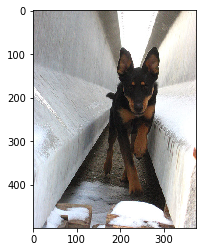

Greedy: dog jumps over barrier


In [64]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic+".jpg")
plt.imshow(x)
plt.show()
print("Greedy:", greedySearch(image))


30


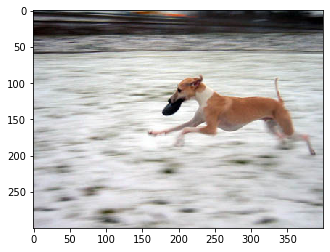

Greedy: brown dog is running through the snow


In [ ]:
from IPython.display import clear_output
import time

images_idx = [1,2, 4, 8, 13, 14, 17, 18, 19, 21, 10, 26, 30, 31, 34, 35, 41,45, 51, 53, 54, 69, 74, 75, 81, 82, 87, 88, 92, 93, 95, 99, 101, 102, 103, 110, 112, 115, 119, 125, 115, 116, 119, 120, 121, 123, 124, 125, 126, 128, 130, 131, 133, 135, 136, 141, 144, 150, 151, 154, 159, 160, 170, 173, 174, 176, 177, 178, 185, 201, 203, 212, 212, 214, 219, 221, 228, 230, 232, 247, 249, 257, 259, 263, 266, 270, 278, 284, 289, 290, 292, 319, 323, 328, 329, 338, 348, 366, 367, 370, 371, 376, 379, 386, 402, 407, 409, 411, 424, 427, 428, 452, 476, 478, 479, 481, 484, 487, 490, 492, 497, 498, 506, 508, 510, 513, 516, 521, 523, 524, 536, 524, 545, 549, 551, 554, 566, 595, 596, 597, 607, 621, 650, 657, 666, 669, 687, 694, 708]

for z in images_idx:
    pic = list(encoding_test.keys())[z]
    print(z)
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic+".jpg")
    plt.imshow(x)
    plt.show()
    print("Greedy:", greedySearch(image))
    clear_output(wait=True)
    input()